In [1]:
import pystan
import pylab as plt
import seaborn as sns
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns
from matplotlib.transforms import Transform
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
%matplotlib inline

# MindLab Model for shelving
There are three variables that could effect whether an item is selected, `product_index`, `product` and `price`. 

$$y_{\alpha,\gamma,\beta}\sim\mbox{binomial}\left( n_{\alpha,\gamma, \beta},p_{\alpha,\gamma,\beta}\right),\mbox{ for } j=1,\dots, J.$$

* $y_{\alpha,\gamma}$ are the responses to a particular product ($\alpha$) at a particular price ($\beta$)and location on shelf ($\gamma$) i.e. `fit`=1 or `does not fit`=0

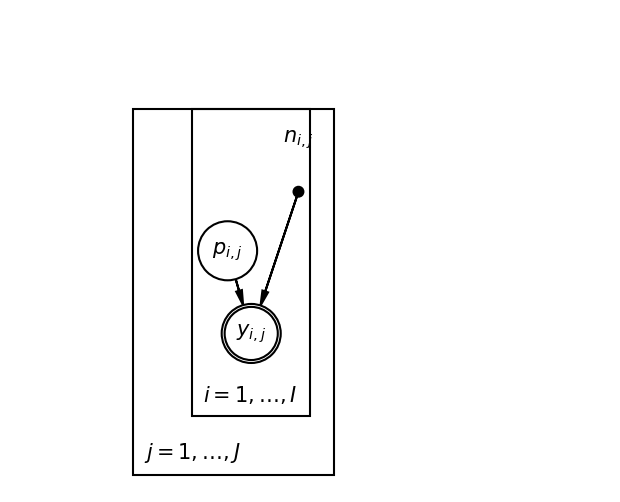

In [5]:
import daft
pgm = daft.PGM(shape=(5,4),observed_style="inner",dpi=150)

pgm.add_node('p',r'$p_{i,j}$',1.8,2)
pgm.add_node('n',r'$n_{i,j}$',2.4,2.5,fixed=True)

pgm.add_node('y',r'$y_{i,j}$',2,1.3,observed=True)
pgm.add_edge('p','y')
pgm.add_edge('n','y')




pgm.add_plate([1.5, 0.7, 1, 2.5], label=r"$i = 1, \ldots, I$", shift=-0.1)
pgm.add_plate([1.0, 0.2, 1.7, 3.0], label=r"$j = 1, \ldots, J$", shift=-0.1)
# Render and save.
pgm.render()
pgm.show()

In [6]:
model="""
data{
int N;
int n_abg[N];
int y[N];
int fit;
}

parameters {
real<lower=0,upper=1.0> p[N];

}

model{
  if (fit > 0){

y~binomial(n_abg,p);
}
}

generated quantities {
int y_pred[N];
for (i in 1:N){
y_pred[i]=binomial_rng(n_abg[i], p[i]);
}
}
"""

In [7]:
sm=pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d88c6dcafb11f1ba23a30f5f07ef7c23 NOW.


In [8]:
data={
    'N':10,
    'n_abg':np.full(10,(100)),
    'y':np.full(10,(0)),
    'fit':0
}

In [9]:
fit=sm.sampling(data=data,chains=1,iter=500)

In [10]:
pystan.diagnostics.check_hmc_diagnostics(fit,verbose=3)

INFO:pystan:n_eff / iter looks reasonable for all parameters
INFO:pystan:Rhat looks reasonable for all parameters
INFO:pystan:No divergent transitions found.
INFO:pystan:No transitions that ended prematurely due to maximum tree depth limit
INFO:pystan:Chain 1: E-BFMI (= 0.865) equals or exceeds threshold of 0.2.
INFO:pystan:E-BFMI indicated no pathological behavior


{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

In [11]:
s=0
data={
    'N':10,
    'n_abg':fit.data['n_abg'],
    'y':fit['y_pred'][s,:].astype(int),
    'fit':1
}

In [12]:
fit_prior=sm.sampling(data=data,chains=1,iter=500)

In [13]:
fit_prior

Inference for Stan model: anon_model_d88c6dcafb11f1ba23a30f5f07ef7c23.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
p[1]         0.02  6.8e-4   0.01 2.5e-3   0.01   0.02   0.03   0.05    407    1.0
p[2]         0.37  2.3e-3   0.05   0.28   0.33   0.37   0.41   0.47    452    1.0
p[3]         0.02  7.0e-4   0.01 3.5e-3   0.01   0.02   0.03   0.06    360    1.0
p[4]         0.58  2.1e-3   0.05   0.49   0.55   0.58   0.61   0.67    491    1.0
p[5]         0.98  6.8e-4   0.01   0.95   0.97   0.98   0.99    1.0    319    1.0
p[6]       8.9e-3  5.7e-4 9.9e-3 9.9e-5 2.5e-3 5.3e-3   0.01   0.03    297    1.0
p[7]         0.52  2.7e-3   0.05   0.42   0.49   0.52   0.55   0.61    352    1.0
p[8]         0.19  1.8e-3   0.04   0.12   0.15   0.18   0.21   0.27    518    1.0
p[9]         0.37  2.5e-3   0.05   0.26   0.33   0.37    0.4   0.46    426   

In [14]:
p=fit_prior.data['y']/fit.data['n_abg']
error=np.sqrt(p*(1-p)/fit.data['n_abg'])

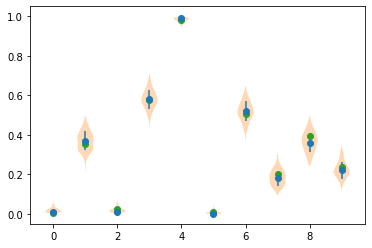

In [15]:
plt.errorbar(np.arange(0,10),p,yerr=error,fmt='o')
plt.violinplot(fit_prior['p'],positions=np.arange(0,10),showextrema=False);
plt.plot(np.arange(0,10),fit['p'][s,:],'o')

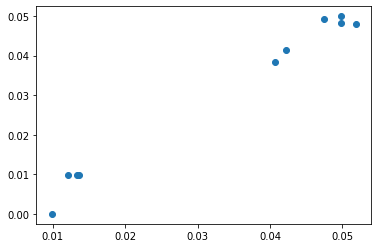

In [16]:
plt.plot(np.std(fit_prior['p'],axis=0),error,'o')